In [3]:
!python -m pip install sqlalchemy

!pip install tabulate
!pip install pandas


In [4]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd

In [8]:
with engine.connect() as conn:
    df = pd.read_sql("SELECT * FROM imdb_movies", conn)
print(df)

                                                title duration  rating voters  \
0                               1. Mahavatar Narsimha   2h 10m     9.2    32K   
1                                            2. Relay   1h 52m     7.3   1.3K   
2                                     3. Freaky Tales   1h 47m     6.3    11K   
3                                   4. Dune: Part Two   2h 46m     8.5   660K   
4                                     5. Gladiator II   2h 28m     6.5   270K   
...                                               ...      ...     ...    ...   
7967                        2245. Mind and Distortion      57m     NaN   None   
7968  2246. Yean Yeathuku Yeppadi from Dishoreabinash      49m     NaN   None   
7969                                  2247. The Birth     None     NaN   None   
7970                                  2248. Seclusion      18m     NaN   None   
7971                            2249. Drive All Night     None     NaN   None   

         genre  
0       Ac

In [9]:


# --- TiDB Connection Details ---
user = "2JRRhPHCS6mRsGW.root"
password = "mt2YyedoEbMz4suV"
host = "gateway01.ap-southeast-1.prod.aws.tidbcloud.com"
port = 4000

# Step 1: Connect without selecting a database
conn = pymysql.connect(
    host=host,
    user=user,
    password=password,
    port=port,
    ssl={"ssl_verify_cert": True, "ssl_verify_identity": True}
)

cur = conn.cursor()
cur.execute("CREATE DATABASE IF NOT EXISTS imdb;")
print("✅ Database `imdb` created (or already exists).")

cur.close()
conn.close()


✅ Database `imdb` created (or already exists).


In [10]:


database = "imdb"

engine = create_engine(
    f"mysql+pymysql://{user}:{password}@{host}:{port}/{database}",
    connect_args={
        "ssl": {
            "ssl_verify_cert": True,
            "ssl_verify_identity": True
        }
    }
)

# Save DataFrame to TiDB
df.to_sql(
    "imdb_movies",
    con=engine,
    if_exists="replace",
    index=False
)

print("🎉 DataFrame stored in TiDB -> imdb.imdb_movies")


🎉 DataFrame stored in TiDB -> imdb.imdb_movies


In [11]:
# --- Query Data back into Pandas ---
from tabulate import tabulate

df_movies = pd.read_sql("SELECT * FROM imdb_movies LIMIT 20;", engine)

# --- Display as Table using tabulate ---
print(tabulate(df_movies, headers="keys", tablefmt="psql", showindex=False))

+------------------------------------------+------------+----------+----------+---------+
| title                                    | duration   |   rating | voters   | genre   |
|------------------------------------------+------------+----------+----------+---------|
| 1. Mahavatar Narsimha                    | 2h 10m     |      9.2 | 32K      | Action  |
| 2. Relay                                 | 1h 52m     |      7.3 | 1.3K     | Action  |
| 3. Freaky Tales                          | 1h 47m     |      6.3 | 11K      | Action  |
| 4. Dune: Part Two                        | 2h 46m     |      8.5 | 660K     | Action  |
| 5. Gladiator II                          | 2h 28m     |      6.5 | 270K     | Action  |
| 6. The Beekeeper                         | 1h 45m     |      6.3 | 167K     | Action  |
| 7. The Ministry of Ungentlemanly Warfare | 2h 2m      |      6.8 | 144K     | Action  |
| 8. Deadpool & Wolverine                  | 2h 8m      |      7.5 | 523K     | Action  |
| 9. Drive

In [ ]:
#1.Top 10 Movies by Rating and Voting Counts
from tabulate import tabulate

query = """
SELECT title, rating, voters
FROM imdb_movies
WHERE rating IS NOT NULL AND voters IS NOT NULL
ORDER BY voters DESC, rating DESC
LIMIT 10;
"""

# use a fresh connection so you don’t hit PendingRollbackError
with engine.connect() as conn:
    df_sorted = pd.read_sql(query, conn)

print(tabulate(df_sorted, headers="keys", tablefmt="psql", showindex=False))


+-------------------------+----------+----------+
| title                   |   rating |   voters |
|-------------------------+----------+----------|
| Dune: Part Two          |      8.5 |   660000 |
| Dune: Part Two          |      8.5 |   660000 |
| Deadpool & Wolverine    |      7.5 |   523000 |
| Deadpool & Wolverine    |      7.5 |   523000 |
| The Substance           |      7.2 |   333000 |
| Furiosa: A Mad Max Saga |      7.5 |   299000 |
| Furiosa: A Mad Max Saga |      7.5 |   299000 |
| Gladiator II            |      6.5 |   270000 |
| Gladiator II            |      6.5 |   270000 |
| Alien: Romulus          |      7.1 |   263000 |
+-------------------------+----------+----------+


In [14]:
#2.Genre Distribution

from tabulate import tabulate
import pandas as pd

query = """
SELECT genre, COUNT(*) AS movie_count
FROM imdb_movies
WHERE genre IS NOT NULL
GROUP BY genre
ORDER BY movie_count DESC;
"""

# use a fresh connection
with engine.connect() as conn:
    df_genre = pd.read_sql(query, conn)

print(tabulate(df_genre, headers="keys", tablefmt="psql", showindex=False))


+-----------+---------------+
| genre     |   movie_count |
|-----------+---------------|
| Thriller  |          2249 |
| Horror    |          1772 |
| Action    |          1404 |
| Romance   |          1232 |
| Mystery   |           692 |
| Adventure |           623 |
+-----------+---------------+


In [17]:
#3.Average Movie Duration by Genre
from tabulate import tabulate
import pandas as pd

query = """
SELECT genre, ROUND(AVG(duration), 2) AS avg_duration
FROM imdb_movies
WHERE genre IS NOT NULL AND duration IS NOT NULL
GROUP BY genre
ORDER BY avg_duration DESC;
"""

with engine.connect() as conn:
    df_duration = pd.read_sql(query, conn)

print(tabulate(df_duration , headers="keys", tablefmt="psql", showindex=False))



+-----------+----------------+
| genre     |   avg_duration |
|-----------+----------------|
| Action    |         102.58 |
| Romance   |         101.06 |
| Thriller  |          98.61 |
| Mystery   |          96.62 |
| Adventure |          95.26 |
| Horror    |          90.33 |
+-----------+----------------+


In [20]:
#4.Voting Trends by Genre
import pandas as pd
from sqlalchemy import create_engine



query = """
SELECT genre, AVG(voters) AS avg_voters
FROM imdb_movies
WHERE genre IS NOT NULL AND voters IS NOT NULL
GROUP BY genre
ORDER BY avg_voters DESC;
"""

with engine.connect() as conn:
    df_votes = pd.read_sql(query, conn)
print(tabulate(df_votes , headers="keys", tablefmt="psql", showindex=False))


+-----------+--------------+
| genre     |   avg_voters |
|-----------+--------------|
| Adventure |     11534.5  |
| Action    |      9433.67 |
| Thriller  |      6862.45 |
| Mystery   |      6422.45 |
| Romance   |      4740.35 |
| Horror    |      4268.5  |
+-----------+--------------+


In [ ]:
!pip install matplotlib seaborn
!pip install plotly as px
!pip install nbformat


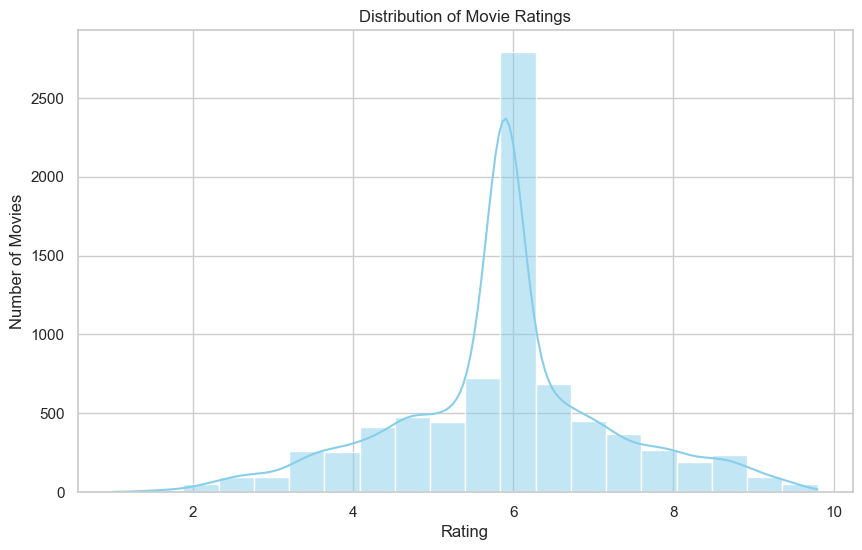

In [34]:
#5.Rating Distribution Visualization


import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

plt.figure(figsize=(10,6))
sns.histplot(df_ratings['rating'], bins=20, kde=True, color='skyblue')
plt.title("Distribution of Movie Ratings")
plt.xlabel("Rating")
plt.ylabel("Number of Movies")
plt.show()



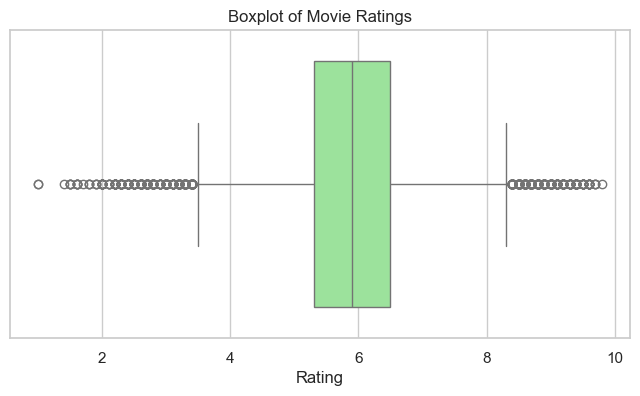

In [35]:
plt.figure(figsize=(8,4))
sns.boxplot(x=df_ratings['rating'], color='lightgreen')
plt.title("Boxplot of Movie Ratings")
plt.xlabel("Rating")
plt.show()


In [ ]:


#6.Genre-Based Rating Leaders

query = """
SELECT genre, title, rating, voters
FROM imdb_movies
WHERE genre IS NOT NULL AND rating IS NOT NULL;
"""

with engine.connect() as conn:
    df_movies = pd.read_sql(query, conn)

# Sort by genre, rating descending, voters descending
df_sorted = df_movies.sort_values(['genre', 'voters', 'rating'], ascending=[True, False, False])

# Keep only the top-rated movie per genre
df_top_per_genre = df_sorted.groupby('genre', as_index=False).first()

# Display table like your example
print(tabulate(df_top_per_genre, headers="keys", tablefmt="psql", showindex=False))



+-----------+----------------+----------+----------+
| genre     | title          |   rating |   voters |
|-----------+----------------+----------+----------|
| Action    | Dune: Part Two |      8.5 |   660000 |
| Adventure | Dune: Part Two |      8.5 |   660000 |
| Horror    | The Substance  |      7.2 |   333000 |
| Mystery   | Nosferatu      |      7.2 |   228000 |
| Romance   | The Fall Guy   |      6.8 |   233000 |
| Thriller  | Alien: Romulus |      7.1 |   263000 |
+-----------+----------------+----------+----------+


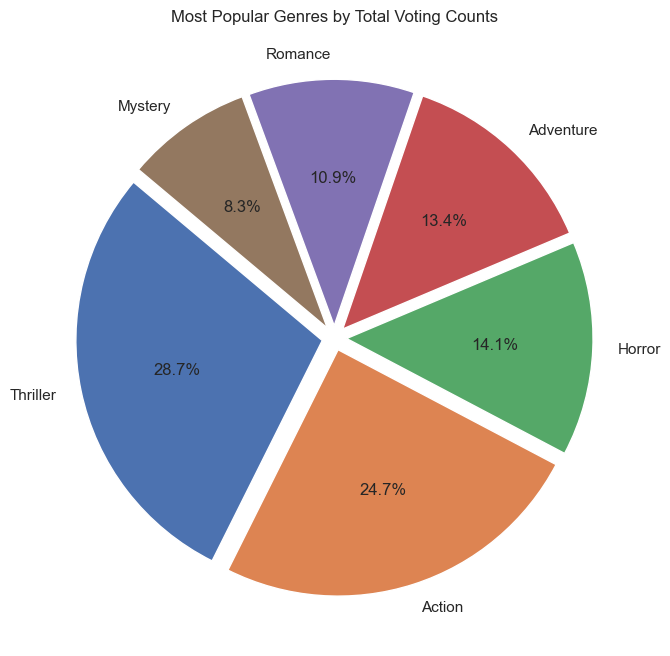

In [46]:
#7.Most Popular Genres by Voting Counts
# Fetch data from your database
query = """
SELECT genre, voters
FROM imdb_movies
WHERE genre IS NOT NULL AND voters IS NOT NULL;
"""

with engine.connect() as conn:
    df = pd.read_sql(query, conn)


# Aggregate total voters per genre
genre_votes = df.groupby('genre')['voters'].sum().sort_values(ascending=False)

# Plot pie chart
plt.figure(figsize=(8,8))
plt.pie(genre_votes, labels=genre_votes.index, autopct='%1.1f%%', startangle=140, explode=[0.05]*len(genre_votes))
plt.title("Most Popular Genres by Total Voting Counts")
plt.show()

In [57]:
#8.Duration Extremes
with engine.connect() as conn:
    # Shortest 5 movies
    df_shortest = pd.read_sql("""
        SELECT 'Shortest' AS type, title, genre, duration
        FROM imdb_movies
        WHERE duration IS NOT NULL
        ORDER BY duration ASC
        LIMIT 5;
    """, conn)

    # Longest 5 movies
    df_longest = pd.read_sql("""
        SELECT 'Longest' AS type, title, genre, duration
        FROM imdb_movies
        WHERE duration IS NOT NULL
        ORDER BY duration DESC
        LIMIT 5;
    """, conn)

# Combine both
df_duration_extremes = pd.concat([df_shortest, df_longest], ignore_index=True)

# Display
from tabulate import tabulate
print(tabulate(df_duration_extremes, headers="keys", tablefmt="psql", showindex=False))


+----------+--------------------------------------------------------------------+-----------+------------+
| type     | title                                                              | genre     |   duration |
|----------+--------------------------------------------------------------------+-----------+------------|
| Shortest | Plots of the preying eyes                                          | Action    |          1 |
| Shortest | Asesinatos en la costa azul                                        | Thriller  |          2 |
| Shortest | The Vent                                                           | Action    |          3 |
| Shortest | The Vent                                                           | Horror    |          3 |
| Shortest | Echoes of Crystal Lake: A Friday the 13th Story                    | Horror    |          3 |
| Longest  | Pedazo del Alma                                                    | Action    |        540 |
| Longest  | In Search of Darkness 19

+-----------+----------+
| genre     |   rating |
|-----------+----------|
| Action    |  5.98362 |
| Adventure |  5.98748 |
| Horror    |  5.45779 |
| Mystery   |  5.99277 |
| Romance   |  6.18393 |
| Thriller  |  5.91792 |
+-----------+----------+


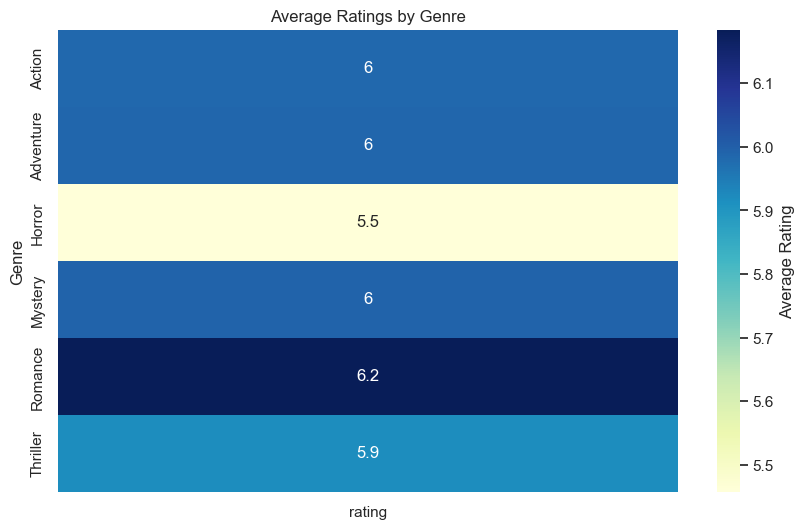

In [62]:
#9.Heatmap of Ratings by Genre



# Fetch data
query = """
SELECT genre, rating
FROM imdb_movies
WHERE genre IS NOT NULL AND rating IS NOT NULL;
"""

with engine.connect() as conn:
    df = pd.read_sql(query, conn)

# Compute average rating per genre
avg_ratings = df.groupby('genre')['rating'].mean().reset_index()
# Display
from tabulate import tabulate
print(tabulate(avg_ratings, headers="keys", tablefmt="psql", showindex=False))



# Convert to a format suitable for heatmap (genre as index)
heatmap_data = avg_ratings.pivot_table(index='genre', values='rating')

# Plot
plt.figure(figsize=(10,6))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Average Rating'})
plt.title("Average Ratings by Genre")
plt.ylabel("Genre")
plt.xlabel("")
plt.show()



+----------+----------+
|   rating |   voters |
|----------+----------|
|      9.2 |    32000 |
|      7.3 |    13000 |
|      6.3 |    11000 |
|      8.5 |   660000 |
|      6.5 |   270000 |
|      6.3 |   167000 |
|      6.8 |   144000 |
|      7.5 |   523000 |
|      5.4 |    25000 |
|      6.5 |   178000 |
|      5.7 |    48000 |
|      7.5 |   299000 |
|      6.8 |    95000 |
|      5.5 |    71000 |
|      6.5 |   182000 |
|      6.8 |   159000 |
|      7   |   250000 |
|      6.8 |   233000 |
|      6.9 |    70000 |
|      6.2 |   174000 |
|      5.5 |    31000 |
|      6   |   138000 |
|      7.6 |    40000 |
|      5.5 |    55000 |
|      4.7 |    52000 |
|      5.2 |     4000 |
|      6.5 |    34000 |
|      6.5 |   103000 |
|      6.4 |    18000 |
|      4.1 |   106000 |
|      5.6 |    96000 |
|      5.6 |    26000 |
|      6.3 |   145000 |
|      6.6 |    55000 |
|      6.5 |   105000 |
|      7.6 |    57000 |
|      6.8 |    95000 |
|      8.4 |    73000 |
|      5.5 |    

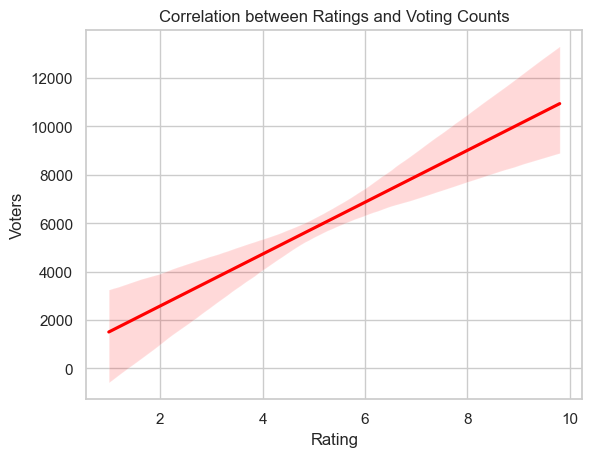

Pearson correlation between rating and voters: 0.06


In [67]:


#10.Correlation between Ratings and Voting Counts

# Fetch data from your database
query = """
SELECT rating, voters
FROM imdb_movies
WHERE rating IS NOT NULL AND voters IS NOT NULL;
"""

with engine.connect() as conn:
    df = pd.read_sql(query, conn)

# Display
from tabulate import tabulate
print(tabulate(df,headers="keys", tablefmt="psql", showindex=False))

# Optional: add regression line to see trend
sns.regplot(x='rating', y='voters', data=df, scatter=False, color='red')

plt.title("Correlation between Ratings and Voting Counts")
plt.xlabel("Rating")
plt.ylabel("Voters")
plt.show()

# Optional: compute correlation
correlation = df['rating'].corr(df['voters'])
print(f"Pearson correlation between rating and voters: {correlation:.2f}")
